<a href="https://colab.research.google.com/github/saeedahmadicp/Machine-Learning-and-Deep-Learning/blob/main/COMP2712_8715_2021_Assignment03_Small_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP2712_8715_2021 Assignment03: Classifying Images Using CNN 

##Part b) Small Convolutional Neural Network



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Functions to work with CIFAR

The functions below help with access to the CIFAR-10 data the you have downloaded.

In [ ]:
import pickle
import numpy as np
import pandas as pd

def load_CIFAR_batch(filename, flatten=True, categorical=True):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='bytes')
        X = datadict[b'data']        
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        if (flatten):
          X = X.reshape(10000, 3072)
        X = X.astype('float32')
        X /= 255

        y = datadict[b'labels']
        y = np.array(y)
        if (categorical):
          y = pd.get_dummies(y).values

        return X, y

def load_CIFAR_meta(filename):
  with open(filename,'rb') as f:
    metadict = pickle.load(f, encoding='bytes')

    class_labels = [ val.decode() for val in metadict.get(b'label_names') ]
    return class_labels

def get_image(X, index, nchans=3, size=32):
  xi = X[index,:]
  img = xi.reshape(32, 32, 3)
  return img

## Load the CIFAR data

The CIFAR data has 5 batches of data and 1 test data set. Each batch is labelled
- `data_batch_1`
- `data_batch_2`
- `data_batch_3`
- `data_batch_4`
- `data_batch_5`

and a test set labelled
- `test_batch`

each batch has 10,000 images, so 50,000 training and 10,000 test images.

Below is example of loading the first batch of training data labelled as `data_batch_1`.  You will need to update the path to match where you have stored your cifar-10 data.

In [ ]:
flatten = False
categorical = True

# load only the first batch
X1, y1 = load_CIFAR_batch('/content/drive/MyDrive/Dataset/cifar-10-batches-py/data_batch_1',flatten=flatten,categorical=categorical)

# load only the second batch
#X2, y2 = load_CIFAR_batch('/content/drive/MyDrive/Dataset/cifar-10-batches-py/data_batch_2',flatten=flatten,categorical=categorical)

# Load the first batch from CIFAR-10
X, y = load_CIFAR_batch('/content/drive/MyDrive/Dataset/cifar-10-batches-py/data_batch_1',flatten=flatten,categorical=categorical)

# iterate over 2 to 5
for bi in range(2,6):
  # load the next data set 'bi'
  X2, y2 = load_CIFAR_batch('/content/drive/MyDrive/Dataset/cifar-10-batches-py/data_batch_{}'.format(bi),flatten=flatten,categorical=categorical)

  # concatenate/stack the dataest together
  X = np.vstack([X, X2])
  y = np.vstack([y, y2])


print('We have {} instances of images'.format(y.shape[0]))


We have 50000 instances of images


The number of instances/examples for all the different classes.  There are 10 different classes.

In [ ]:
[np.sum(np.argmax(y, axis=1) == i) for i in range(0,10)]

[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]

The labels for the classes are stored in the `batches.meta` file

In [ ]:
class_labels = load_CIFAR_meta('/content/drive/MyDrive/Dataset/cifar-10-batches-py/batches.meta')
print(class_labels)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Let's look at some random cat images, because cats.

In [ ]:
import random
import matplotlib.pyplot as plt

def plot_random(X, y, class_labels, what_target='cat'):

  what_label = class_labels.index(what_target)
  what_labeli = np.where(np.argmax(y,axis=1) == what_label)[0]
  random_what_index = what_labeli[random.choice(range(len(what_labeli)))]

  plt.imshow(get_image(X,random_what_index))
  plt.title('{}, index: {}'.format(what_target,random_what_index))
  plt.axis('off')

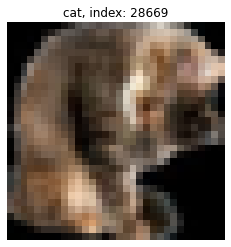

In [ ]:
plot_random(X, y, class_labels, what_target='cat')


## Part b) Small Convolutional Neural Netowrk



In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input

def build_small_cnn(number_of_output, input_shape):
    model_cnn = keras.Sequential()
    model_cnn.add(Input(input_shape))
    
    model_cnn.add(Conv2D(32, kernel_size=(5,5), activation="relu"))
    model_cnn.add(Conv2D(32, kernel_size=(3,3), activation="relu"))
    model_cnn.add(MaxPooling2D(pool_size=(2,2)))

    model_cnn.add(Flatten())
    model_cnn.add(Dense(128, activation='relu'))

    #output layer for classification
    model_cnn.add(Dense(number_of_output, activation='softmax'))
    
    model_cnn.compile(optimizer= tf.optimizers.Adam(),
                      loss=keras.losses.categorical_crossentropy,
                      metrics=keras.metrics.categorical_crossentropy)
    return model_cnn

### Flatten the data
The data is currently a 3D image, but for the simple model we require a 1D feature vector.  So, we need to flatten the data.

In [ ]:
# we need to flatten the images for the simple model
n_samples = len(X)
X_flatten = X.reshape((n_samples, -1))

print('The number of samples: {}'.format(n_samples))
print('The old shape of the data: {}'.format(X.shape))
print('The new shape of the data: {}'.format(X_flatten.shape))
print('The shape of the y       : {}'.format(y.shape))

The number of samples: 50000
The old shape of the data: (50000, 32, 32, 3)
The new shape of the data: (50000, 3072)
The shape of the y       : (50000, 10)


### Train the model



In [ ]:
# sklearn evaluation packages
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef

# use 5 epochs or iterations
no_epochs = 5
number_of_features = len(X_flatten[0])

# with 50 nodes in the single hidden layer
number_hidden_nodes = 50
number_of_output = len(y[0])

# relu is a good choice
activation = 'relu' # select from [None, 'sigmoid', 'tanh', 'relu']:
y_class = np.argmax(y, axis=1)

# build a small cnn model
model = build_small_cnn(number_of_output=number_of_output, input_shape=(32,32,3))
model.summary()


# Stratified K-Fold for evaluation of generalisation performance
k = 5 # 10 is the gold standard
kf = StratifiedKFold(n_splits=k)
foldi = 1
ac = [] # accuracy_score
cr = [] # classification_report
cm = [] # confusion_matrix
y_test_max_all = []
y_pred_max_all = []


for train_index, test_index in kf.split(X,y_class):
  X_train, X_test, y_train, y_test = X[train_index,:], X[test_index,:], y[train_index,:], y[test_index,:]

  model = build_small_cnn(number_of_output=number_of_output, input_shape=(32,32,3))

  print('Training with {0} for {1} for fold {2} or {3}'.format(activation, no_epochs, foldi, k))
  history = model.fit(X_train, y_train, epochs=no_epochs, verbose=1)

  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch


  loss_final = np.sqrt(float(hist['loss'].tail(1)))
  print()
  print('Final Loss on training set: {}'.format(round(loss_final, 3)))

  # evaluate the model
  y_pred_real = model.predict(X_test)
  y_pred_max = np.argmax(y_pred_real, axis=-1).astype(int)
  y_test_max = y_test.argmax(axis=1).astype(int)

  y_pred_max_all.extend(y_pred_max)
  y_test_max_all.extend(y_test_max)

  ac.append(accuracy_score(y_test_max,y_pred_max))
  print('accuracy is {:.2f}%'.format(ac[-1]*100)) # Print accuracy score
  print()
  cr.append(classification_report(y_test_max,y_pred_max)) # Print summary report
  cm.append(confusion_matrix(y_test_max, y_pred_max))
  
  foldi = foldi + 1

print('k-fold complete!')

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               692352    
_________________________________________________________________
dense_19 (Dense)             (None, 10)                1290      
Total params: 705,322
Trainable params: 705,322
Non-trainable params: 0
________________________________________________

In [ ]:
print('Average Accuracy for {}-CV: {}% +/- {}% SD'.format(k, np.round(np.mean(ac)*100,2), np.round(np.std(ac)*100,2)))

Average Accuracy for 5-CV: 64.54% +/- 0.23% SD


In [ ]:
acc_all = accuracy_score(y_test_max_all,y_pred_max_all)*100
print('Accuracy: {:.2f}%'.format(acc_all))
print()
print(classification_report(y_test_max_all,y_pred_max_all)) 
print(confusion_matrix(y_test_max_all, y_pred_max_all))

mcc_all = matthews_corrcoef(y_test_max_all,y_pred_max_all)
print()
print('Matthews Correlation Coefficient: {}'.format(mcc_all))

Accuracy: 64.54%

              precision    recall  f1-score   support

           0       0.67      0.71      0.68      5000
           1       0.77      0.75      0.76      5000
           2       0.53      0.53      0.53      5000
           3       0.48      0.41      0.44      5000
           4       0.55      0.60      0.58      5000
           5       0.57      0.51      0.54      5000
           6       0.65      0.76      0.70      5000
           7       0.73      0.69      0.71      5000
           8       0.74      0.79      0.76      5000
           9       0.74      0.72      0.73      5000

    accuracy                           0.65     50000
   macro avg       0.64      0.65      0.64     50000
weighted avg       0.64      0.65      0.64     50000

[[3526  124  308   97  134   40   60   68  443  200]
 [ 189 3760   57   51   39   25   78   30  253  518]
 [ 363   57 2648  295  592  316  404  156  104   65]
 [ 139   67  442 2033  398  900  587  217  130   87]
 [ 199   28

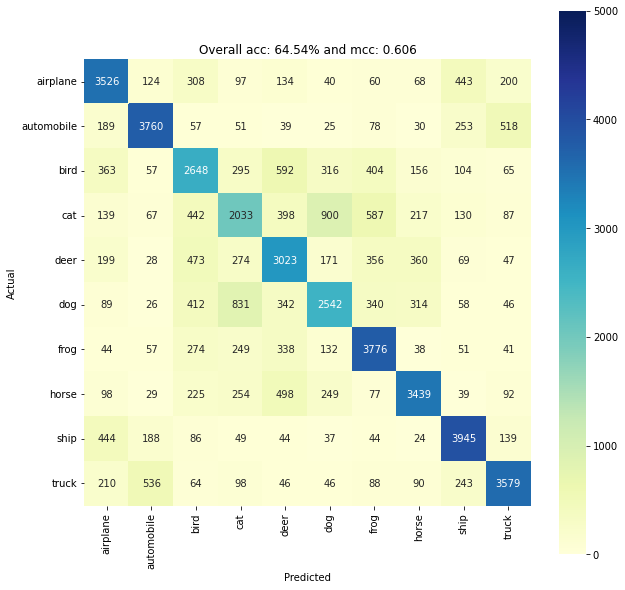

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

cm_all = np.sum(np.stack(cm,axis=2),axis=2)
df_cm = pd.DataFrame(cm_all, columns=class_labels, index=class_labels)
fig, ax1 = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(df_cm, annot=True, ax=ax1,square=True,  cmap="YlGnBu",vmin=0,vmax=5000,fmt='d')
ax1.set_title('Overall acc: {:.2f}% and mcc: {:.3f}'.format(acc_all,mcc_all))
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual');